In [1]:
import numpy as np
import wfdb
import pandas as pd
from glob import glob
import os
import biosppy
import pyhrv
import pyhrv.tools as tools
import json
import shap

## Data Pre-processing

In [2]:
data_dir = "data/CPSC/"
recordpaths = glob(os.path.join(data_dir, '*.hea'))

for recordpath in recordpaths:
    patient_id = recordpath.split('/')[-1][:-4]
    signals, meta_data = wfdb.rdsamp(recordpath[:-4])
    sample_rate = meta_data['fs']
    signal_len = meta_data['sig_len']
    age = meta_data['comments'][0]
    sex = meta_data['comments'][1]
    dx = meta_data['comments'][2]
    age = age[5:] if age.startswith('Age: ') else np.NaN
    sex = sex[5:] if sex.startswith('Sex: ') else 'Unknown'
    dx = dx[4:] if dx.startswith('Dx: ') else ''


    folder_path = f"processing/{patient_id}/"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
        for signal in signals.T:
            try:
                # Get R-peaks series using biosppy
                t, filtered_signal, rpeaks = biosppy.signals.ecg.ecg(signal, sampling_rate=500, show=False)[:3]
            except:
                pass
            try:
                HRV_params = pyhrv.hrv(rpeaks=t[rpeaks])
            except:
                pass

            tools.hrv_export(HRV_params, path=folder_path)
    
        df_combined = pd.DataFrame()

        # Loop over each iteration of your for loop
        for filename in os.listdir(folder_path): 

            # Open the current file for reading
            with open(os.path.join(folder_path, filename)) as f:

                # Load the JSON data from the file into a Python object
                data = json.load(f)

                # Convert the Python object to a pandas DataFrame
                df = pd.json_normalize(data)

                # Select columns with at most one value
                cols_with_single_value = [col for col in df.columns if df[col].apply(lambda x: len(x) if isinstance(x, list) else 1).max() <= 1]
                df_with_single_value = df[cols_with_single_value].drop(columns=['Comment', 'Name'])
                df_with_single_value = df_with_single_value.dropna(axis=1)
                df_with_single_value = df_with_single_value._get_numeric_data()

                # Write the data to the combined JSON file

            df_combined = df_combined.append(df_with_single_value, ignore_index=True)

        df_combined.to_csv(f"csv/{patient_id}.csv", index=False)

## HRV Features preparation

In [2]:
# set the path of the directory where csv files are located
directory_path = 'csv'

# create an empty list to store the dataframes for each file
dfs = []
#patient_ids = []
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# loop through each file in the directory
for file in os.listdir(directory_path):
        
        if file.endswith('.csv'):
            patient_id = file[:-4]
            file_path = os.path.join(directory_path, file)


            # read the csv file into a dataframe
            df = pd.read_csv(file_path)
            
            if len(df.T) > 39:
                df = df.drop(["dfa_alpha1", "dfa_alpha2"], axis=1)

            cols = df.columns.tolist()

            # reshape the dataframe to have 1 row and 12*39 columns
            datalist = df.values.reshape((1, -1))
            
            # mean of leads values
            datalistmean = [df.mean().tolist()]

            col_names = []

            for lead in leads:
                for col in cols:
                    col_names.append(col + "_" + lead)
                    
            #datalist = datalist.insert(0, patient_id)
                    
            df = pd.DataFrame(datalist, columns=col_names)
            #df_mean = pd.DataFrame(datalistmean, columns=cols)
            df.insert(0, "patient_id", patient_id)
            #df_mean.insert(0, "patient_id", patient_id)
            
            dfs.append(df)
            
#result = pd.concat(dfs, axis=0, index=patient_ids)
result = pd.concat(dfs, axis=0, ignore_index=True)
result.sort_values(by=["patient_id"], ascending=True, inplace=True)
# check number of unique values in each column
unique_counts = result.nunique()

# get the names of columns with only one unique value
same_values_cols = unique_counts[unique_counts == 1].index.tolist()
# drop the columns with same values
result.drop(same_values_cols, axis=1, inplace=True)

result.to_csv("mean_hrv_across_leads.csv", index=False)

In [3]:
df = pd.read_csv("mean_hrv_across_leads.csv")
df.head(5)

,patient_id,ar_ratio_I,ar_total_I,ellipse_area_I,fft_ratio_I,fft_total_I,hr_max_I,hr_mean_I,hr_min_I,hr_std_I,...,sampen_V6,sd1_V6,sd2_V6,sd_ratio_V6,sdnn_V6,sdsd_V6,tinn_V6,tinn_m_V6,tinn_n_V6,tri_index_V6
0,A0001,0.535602,20371.138078,103.834434,1.823748,11.410690,102.389078,100.629323,98.684211,1.002042,...,inf,6.074350,5.747170,0.946137,6.039396,4.633073,23.4375,601.5625,578.1250,2.300000
1,A0002,0.531833,22085.091780,932.561012,1.199687,197.238932,81.632653,77.863732,76.142132,1.935193,...,0.693147,13.246886,21.970435,1.658536,18.628424,14.803903,0.0000,0.0000,0.0000,1.833333
2,A0003,0.543473,19652.318087,14365.350283,0.272775,2339.220599,183.486239,148.206983,109.890110,22.291827,...,inf,60.004611,76.587211,1.276355,69.363900,50.756187,70.3125,398.4375,328.1250,7.333333
3,A0004,0.496874,21520.621770,47628.549496,0.317893,11809.218464,164.835165,122.129497,72.463768,26.262466,...,inf,118.374702,128.695260,1.087186,123.815550,109.470015,15.6250,421.8750,406.2500,10.500000
4,A0005,0.544777,18793.484985,206.267617,1.321568,28.192295,124.740125,119.879137,114.503817,1.984129,...,0.403225,31.189963,19.736233,0.632775,26.117344,42.157102,39.0625,515.6250,476.5625,2.764706


In [4]:
# Check for duplicate columns and drop them
df = df.loc[:,~df.T.duplicated(keep='first')]
classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
data_dir = "data/CPSC/"
df_labels = pd.read_csv(os.path.join(data_dir,"labels.csv"))
df_X = df
sel_ids = df_X["patient_id"].tolist()
df_labels = df_labels[df_labels['patient_id'].isin(sel_ids)]
df_X.replace([np.inf, -np.inf], 100000, inplace=True)
df_X = df_X.merge(df_labels[['patient_id', 'fold']], on='patient_id')
df_X

,patient_id,ar_ratio_I,ar_total_I,ellipse_area_I,fft_ratio_I,fft_total_I,hr_max_I,hr_mean_I,hr_min_I,hr_std_I,...,sd1_V6,sd2_V6,sd_ratio_V6,sdnn_V6,sdsd_V6,tinn_V6,tinn_m_V6,tinn_n_V6,tri_index_V6,fold
0,A0001,0.535602,20371.138078,103.834434,1.823748,11.410690,102.389078,100.629323,98.684211,1.002042,...,6.074350,5.747170,0.946137,6.039396,4.633073,23.4375,601.5625,578.1250,2.300000,8
1,A0002,0.531833,22085.091780,932.561012,1.199687,197.238932,81.632653,77.863732,76.142132,1.935193,...,13.246886,21.970435,1.658536,18.628424,14.803903,0.0000,0.0000,0.0000,1.833333,7
2,A0003,0.543473,19652.318087,14365.350283,0.272775,2339.220599,183.486239,148.206983,109.890110,22.291827,...,60.004611,76.587211,1.276355,69.363900,50.756187,70.3125,398.4375,328.1250,7.333333,10
3,A0004,0.496874,21520.621770,47628.549496,0.317893,11809.218464,164.835165,122.129497,72.463768,26.262466,...,118.374702,128.695260,1.087186,123.815550,109.470015,15.6250,421.8750,406.2500,10.500000,9
4,A0005,0.544777,18793.484985,206.267617,1.321568,28.192295,124.740125,119.879137,114.503817,1.984129,...,31.189963,19.736233,0.632775,26.117344,42.157102,39.0625,515.6250,476.5625,2.764706,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6812,A6873,0.530852,21653.583698,4104.719066,0.697794,1993.025890,78.125000,72.803866,65.288357,3.270762,...,28.187781,46.210256,1.639372,38.295468,28.069772,31.2500,804.6875,773.4375,5.000000,7
6813,A6874,0.530824,22216.521930,1363.356637,2.789007,567.904902,61.538462,58.956432,56.179775,1.373819,...,14.505661,29.566093,2.038245,23.636557,11.339742,62.5000,1046.8750,984.3750,4.666667,2
6814,A6875,0.547755,17990.324254,149.485956,8.431902,133.946767,107.334526,101.804540,99.502488,1.633116,...,19.212254,16.081199,0.837028,17.800264,25.946653,39.0625,609.3750,570.3125,2.838710,3
6815,A6876,0.516221,21187.166804,26565.609847,0.068610,7194.144633,128.205128,102.352005,74.812968,14.940668,...,92.150387,91.530016,0.993268,92.994624,76.373924,46.8750,539.0625,492.1875,7.000000,7


Machine Learning classifers and application

In [5]:
def split_data(seed=42):
    folds = range(1, 11)
    folds = np.random.RandomState(seed).permutation(folds)
    return folds[:8], folds[8:]

train_folds, test_folds = split_data()
feature_cols = df_X.columns[1:-1] # remove patient id and fold

X_train = df_X[df_X['fold'].isin(train_folds)][feature_cols].to_numpy()
X_test = df_X[df_X['fold'].isin(test_folds)][feature_cols].to_numpy()

# Preprocess the data using standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = df_labels[df_labels['fold'].isin(train_folds)][classes].to_numpy()
y_test = df_labels[df_labels['fold'].isin(test_folds)][classes].to_numpy()

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pickle

Start training RF...
Optimal Threshold: 0.14
SNR Accuracy: 0.6571428571428571, F1_score: 0.38258575197889183
Optimal Threshold: 0.31
AF Accuracy: 0.9582417582417583, F1_score: 0.8991150442477875
Optimal Threshold: 0.1
IAVB Accuracy: 0.5641025641025641, F1_score: 0.2717258261933905
Optimal Threshold: 0.05
LBBB Accuracy: 0.6857142857142857, F1_score: 0.12981744421906694
Optimal Threshold: 0.3
RBBB Accuracy: 0.6263736263736264, F1_score: 0.5114942528735632
Optimal Threshold: 0.23
PAC Accuracy: 0.8871794871794871, F1_score: 0.56
Optimal Threshold: 0.15
PVC Accuracy: 0.8542124542124542, F1_score: 0.5507900677200902
Optimal Threshold: 0.14
STD Accuracy: 0.6117216117216118, F1_score: 0.32911392405063294
Optimal Threshold: 0.05
STE Accuracy: 0.6879120879120879, F1_score: 0.12345679012345677


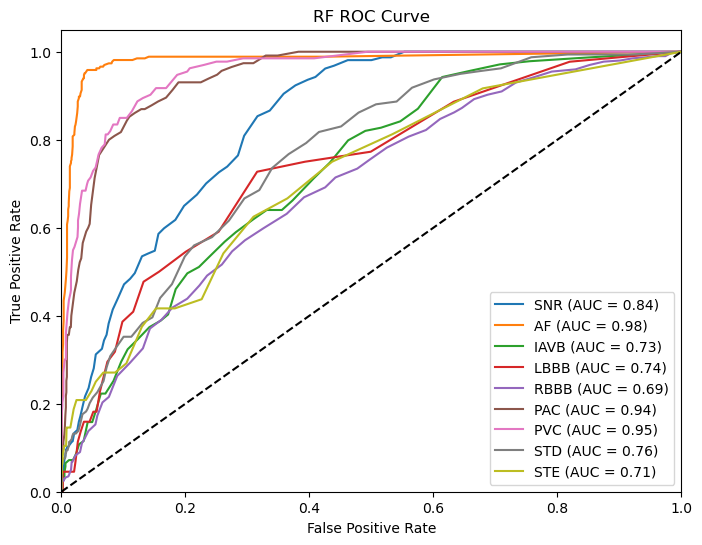

Start training DT...
Optimal Threshold: 1.0
SNR Accuracy: 0.8168498168498168, F1_score: 0.29775280898876405
Optimal Threshold: 1.0
AF Accuracy: 0.9113553113553113, F1_score: 0.7686424474187381
Optimal Threshold: 1.0
IAVB Accuracy: 0.8146520146520146, F1_score: 0.19169329073482427
Optimal Threshold: 1.0
LBBB Accuracy: 0.9252747252747253, F1_score: 0.10526315789473684
Optimal Threshold: 1.0
RBBB Accuracy: 0.6241758241758242, F1_score: 0.34314980793854033
Optimal Threshold: 1.0
PAC Accuracy: 0.8857142857142857, F1_score: 0.38095238095238093
Optimal Threshold: 1.0
PVC Accuracy: 0.8915750915750916, F1_score: 0.4351145038167939
Optimal Threshold: 1.0
STD Accuracy: 0.810989010989011, F1_score: 0.25
Optimal Threshold: 1.0
STE Accuracy: 0.9282051282051282, F1_score: 0.10909090909090909


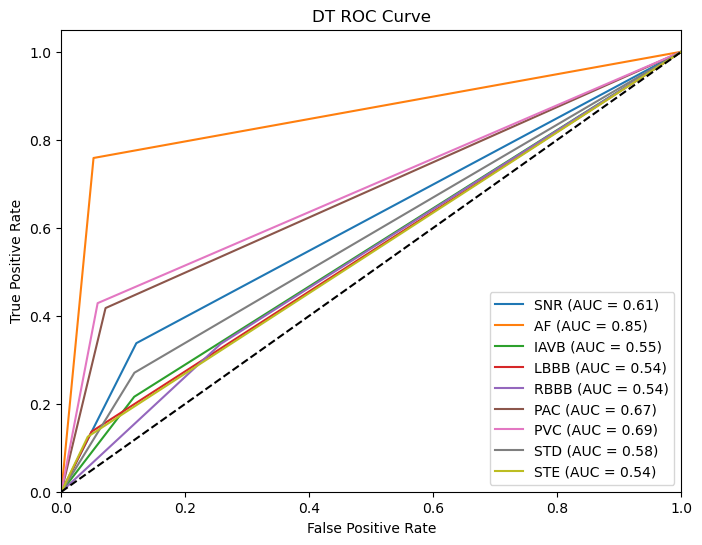

Start training LR...
Optimal Threshold: 0.07113418190814395
SNR Accuracy: 0.610989010989011, F1_score: 0.3625450180072029
Optimal Threshold: 0.2510792943726123
AF Accuracy: 0.9457875457875458, F1_score: 0.8706293706293707
Optimal Threshold: 0.06959059819358826
IAVB Accuracy: 0.5655677655677656, F1_score: 0.27946537059538273
Optimal Threshold: 0.02404339598225792
LBBB Accuracy: 0.621978021978022, F1_score: 0.0851063829787234
Optimal Threshold: 0.24777643413336134
RBBB Accuracy: 0.5794871794871795, F1_score: 0.48841354723707664
Optimal Threshold: 0.04998102903230725
PAC Accuracy: 0.7728937728937729, F1_score: 0.40839694656488545
Optimal Threshold: 0.06045016198065521
PVC Accuracy: 0.8043956043956044, F1_score: 0.45174537987679675
Optimal Threshold: 0.10366932974290054
STD Accuracy: 0.5985347985347985, F1_score: 0.3080808080808081
Optimal Threshold: 0.020491799470122266
STE Accuracy: 0.5772893772893772, F1_score: 0.11638591117917306


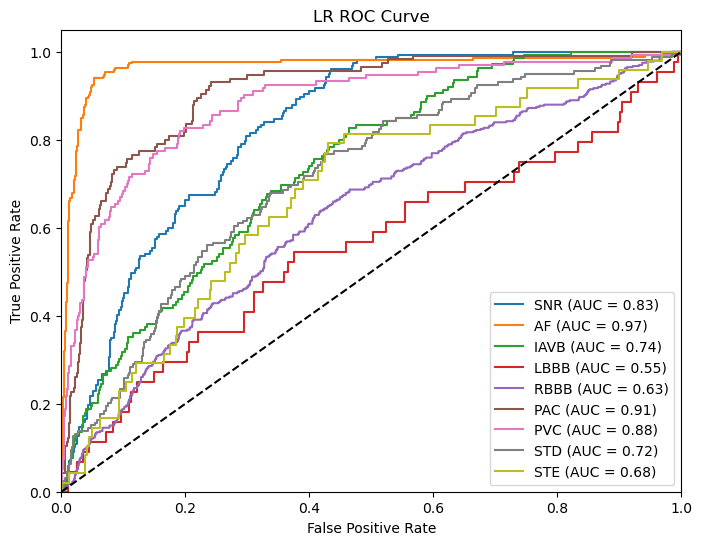

Start training SVM...
Optimal Threshold: 0.11510596636377801
SNR Accuracy: 0.5641025641025641, F1_score: 0.3246311010215664
Optimal Threshold: 0.22226468921340306
AF Accuracy: 0.9582417582417583, F1_score: 0.8976660682226212
Optimal Threshold: 0.10650083062025201
IAVB Accuracy: 0.6278388278388278, F1_score: 0.2594752186588921
Optimal Threshold: 0.03263324049946538
LBBB Accuracy: 0.5728937728937729, F1_score: 0.08763693270735524
Optimal Threshold: 0.2594065887378718
RBBB Accuracy: 0.6285714285714286, F1_score: 0.42189281641961224
Optimal Threshold: 0.07592030306568788
PAC Accuracy: 0.8446886446886447, F1_score: 0.49038461538461536
Optimal Threshold: 0.07310928498061452
PVC Accuracy: 0.8534798534798534, F1_score: 0.54337899543379
Optimal Threshold: 0.11994155256443548
STD Accuracy: 0.6073260073260073, F1_score: 0.26373626373626374
Optimal Threshold: 0.03111712727600349
STE Accuracy: 0.48424908424908425, F1_score: 0.09278350515463916


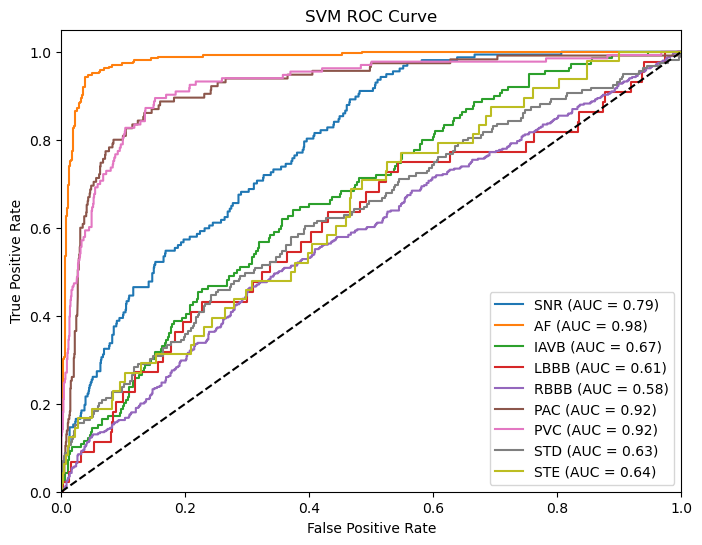

Start training LinerSVC...
Optimal Threshold: 2.4240740476578315e-08
SNR Accuracy: 0.5860805860805861, F1_score: 0.34072345390898484
Optimal Threshold: 0.015623833848879746
AF Accuracy: 0.9362637362637363, F1_score: 0.8522920203735144
Optimal Threshold: 0.0025222782466725754
IAVB Accuracy: 0.7216117216117216, F1_score: 0.3090909090909091
Optimal Threshold: 9.129807519687032e-05
LBBB Accuracy: 0.6285714285714286, F1_score: 0.0994671403197158
Optimal Threshold: 0.026608605983945117
RBBB Accuracy: 0.5941391941391941, F1_score: 0.458984375
Optimal Threshold: 0.000761474058459561
PAC Accuracy: 0.8505494505494505, F1_score: 0.49253731343283585
Optimal Threshold: 0.01764205827400282
PVC Accuracy: 0.8981684981684982, F1_score: 0.5994236311239193
Optimal Threshold: 0.007208750773802825
STD Accuracy: 0.6454212454212455, F1_score: 0.3045977011494253
Optimal Threshold: 5.2567659725539794e-08
STE Accuracy: 0.4673992673992674, F1_score: 0.0946450809464508


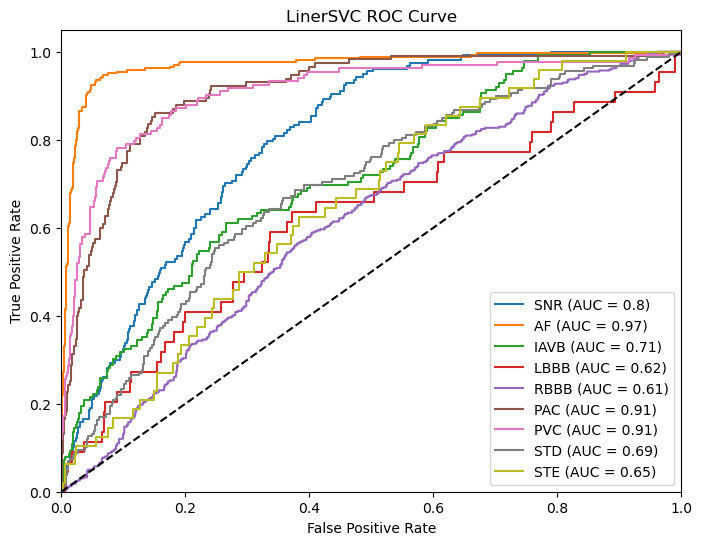

Start training MLP...


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


Optimal Threshold: 0.0005446784390270688
SNR Accuracy: 0.643956043956044, F1_score: 0.3671875
Optimal Threshold: 0.0024788371089275243
AF Accuracy: 0.9106227106227106, F1_score: 0.8
Optimal Threshold: 0.0013987177141538407
IAVB Accuracy: 0.6351648351648351, F1_score: 0.2719298245614035
Optimal Threshold: 2.1433548377306722e-05
LBBB Accuracy: 0.6095238095238096, F1_score: 0.09813874788494079
Optimal Threshold: 0.0029611556867180353
RBBB Accuracy: 0.4835164835164835, F1_score: 0.46952595936794583
Optimal Threshold: 0.00015908776794852747
PAC Accuracy: 0.8366300366300367, F1_score: 0.4677804295942721
Optimal Threshold: 9.913786359056134e-05
PVC Accuracy: 0.8, F1_score: 0.4572564612326043
Optimal Threshold: 0.021405038212317817
STD Accuracy: 0.6410256410256411, F1_score: 0.27941176470588236
Optimal Threshold: 2.8746090743802346e-07
STE Accuracy: 0.43443223443223444, F1_score: 0.09389671361502348


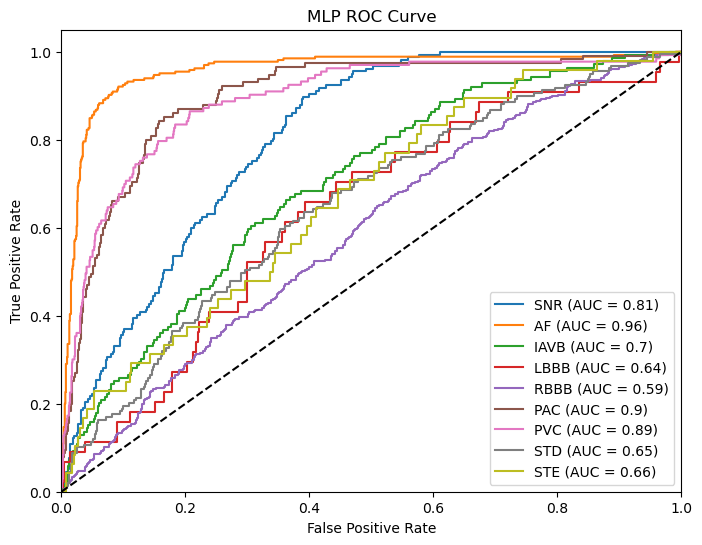

In [7]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
classifiers = ['RF', 'DT', 'LR', 'SVM', 'LinerSVC', 'MLP']
classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']

for classifier in classifiers:
    # tune parameters
    if classifier == 'LR':
        model = LogisticRegression(max_iter=2000)#solver='lbfgs', max_iter=1000)
    elif classifier == 'RF':
        model = RandomForestClassifier()#n_estimators=300, max_depth=10)
    elif classifier == 'SVM':
        model = SVC(probability=True)
    elif classifier == 'LinearSVC':
        model = LinearSVC()
    elif classifier == 'DT':
        model = DecisionTreeClassifier()
    else:
        model = MLPClassifier(max_iter=500) #hidden_layer_sizes=(100, 50), max_iter=500)
    if classifier != 'MLP':
        model = OneVsRestClassifier(model)

    print(f'Start training {classifier}...')
    model.fit(X_train, y_train)
    with open(f'models/model_{classifier}.pkl', 'wb') as file:
        pickle.dump(model, file)
    

    #y_val_scores = model.predict_proba(X_val)
    y_test_scores = model.predict_proba(X_test)
    roc_auc = dict()
    fpr = dict()
    tpr = dict()
    optimal_thresholds = []

    
    plt.figure(figsize=(8,6))
    
    for i in range(len(classes)):
        fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_test_scores[:, i])
        opt_threshold = thresholds[np.argmax(tpr[i]-fpr[i])]
        optimal_thresholds.append(opt_threshold)
        acc = accuracy_score(y_test[:, i], y_test_scores[:, i]>=opt_threshold)
        f1s = f1_score(y_test[:, i], y_test_scores[:, i]>=opt_threshold)
        print('Optimal Threshold:', opt_threshold)
        print(f'{classes[i]} Accuracy: {acc}, F1_score: {f1s}')
        roc_auc[classes[i]] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[classes[i]]:0.2})')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier} ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'results/roc_{classifier}')
    plt.show()
    plt.close()
   # plot_confusion_matrix(y_test, y_test_scores, classes, optimal_thresholds, classifier=classifier)

Start training RF...


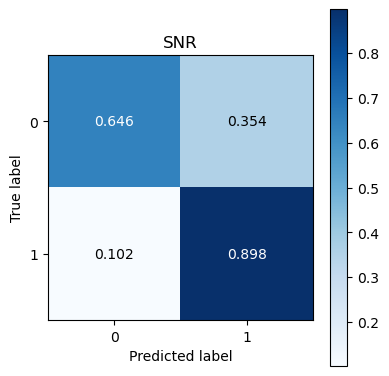

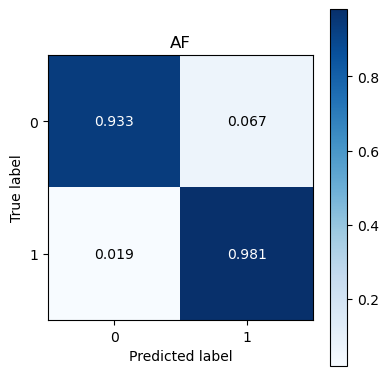

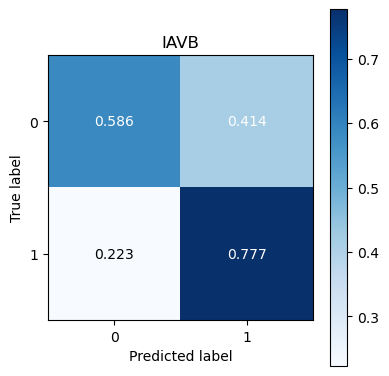

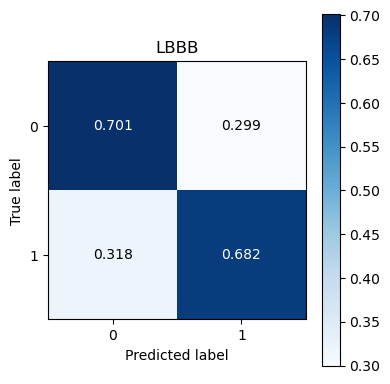

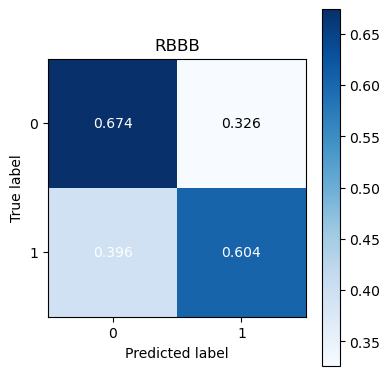

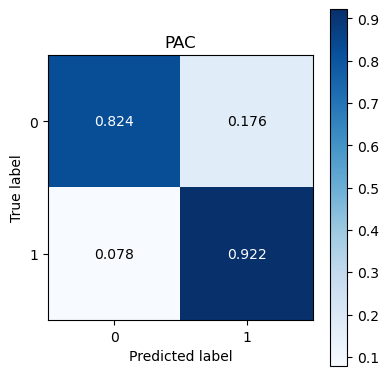

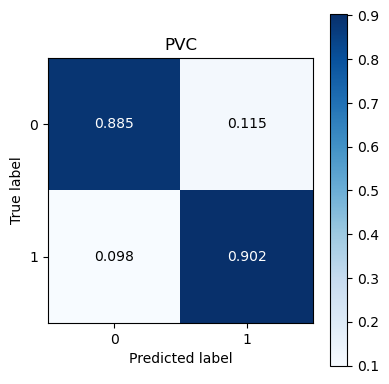

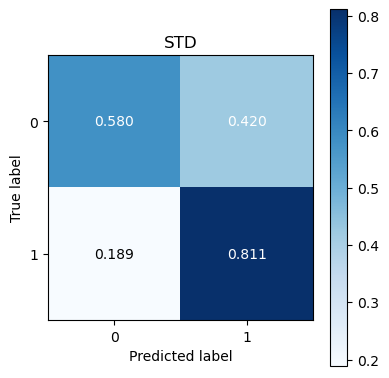

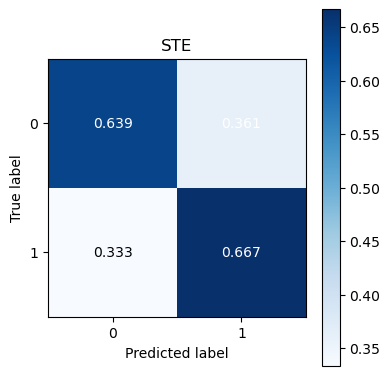

Start training LR...


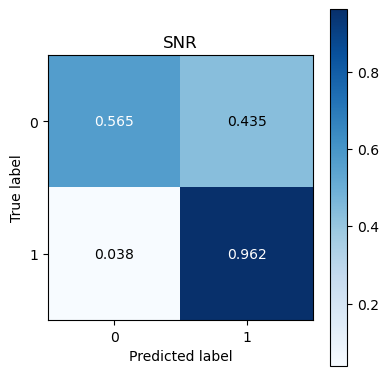

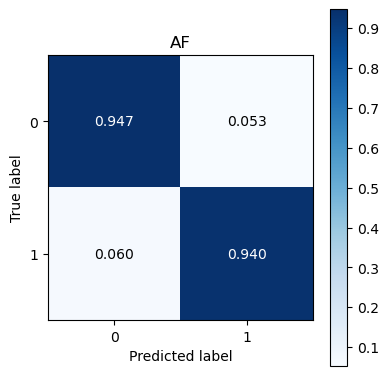

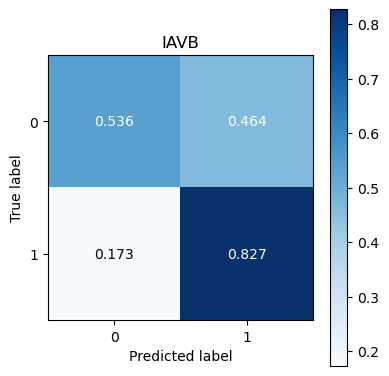

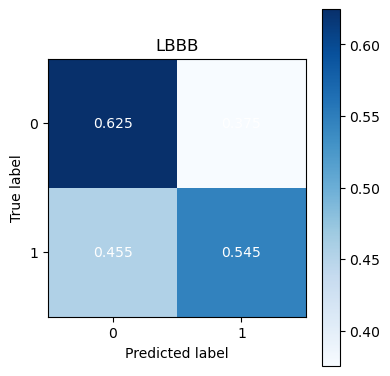

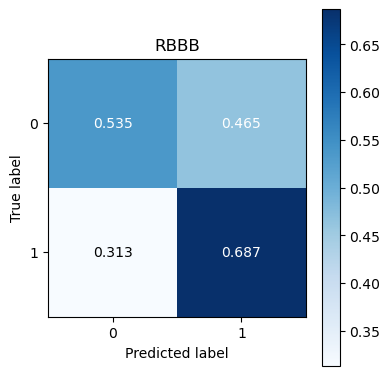

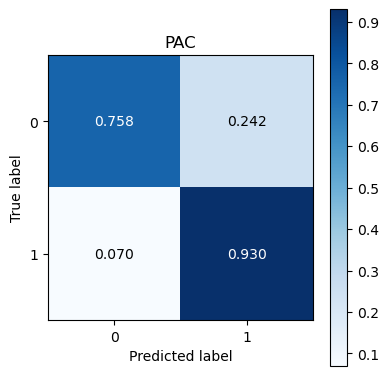

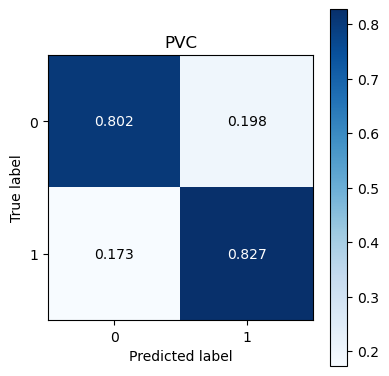

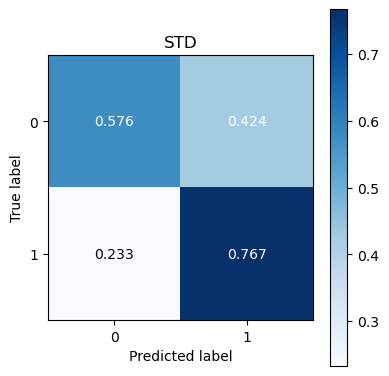

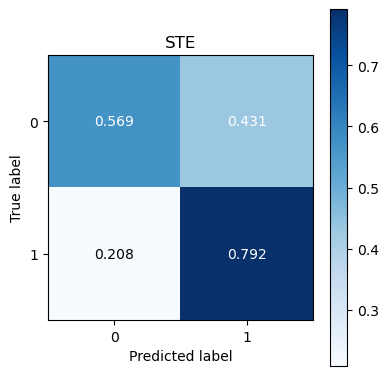

Start training LinerSVC...


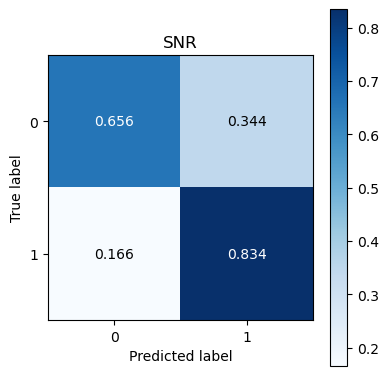

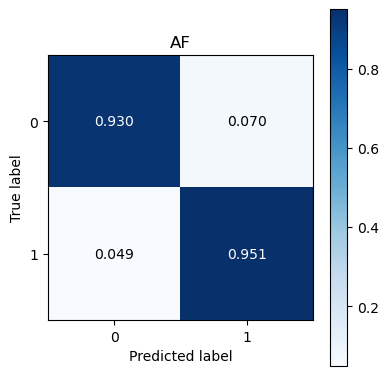

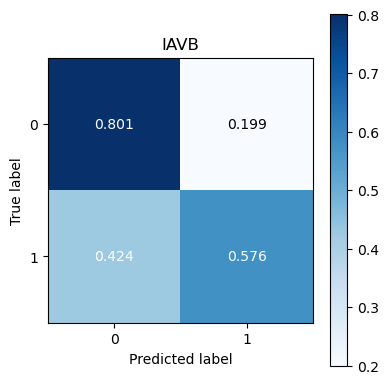

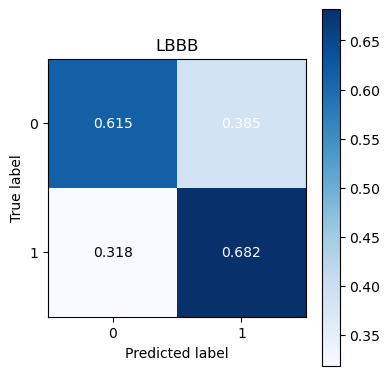

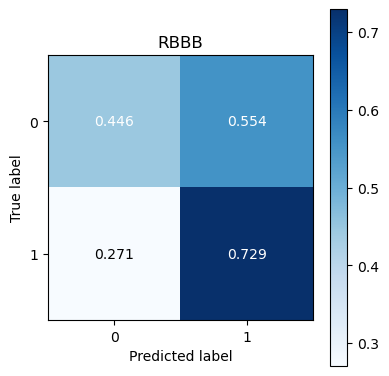

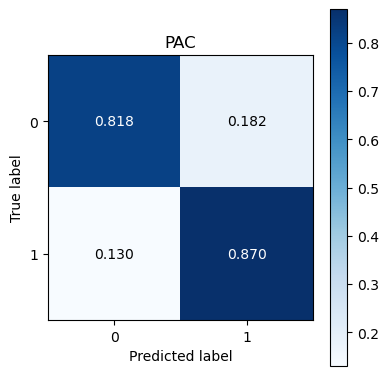

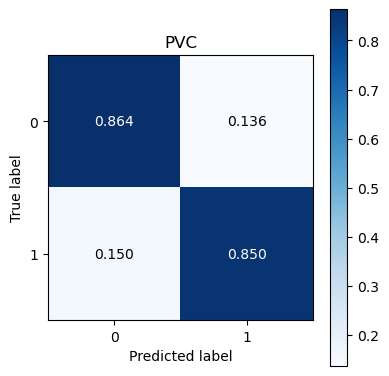

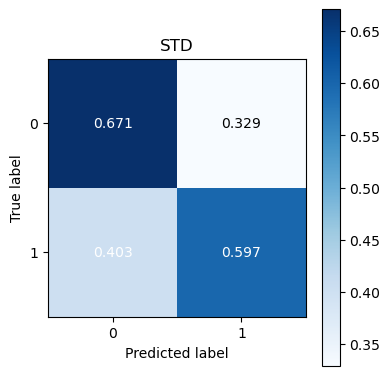

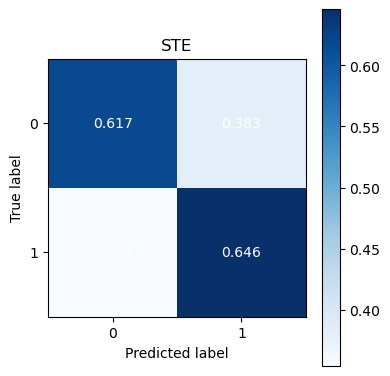

Start training MLP...


Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


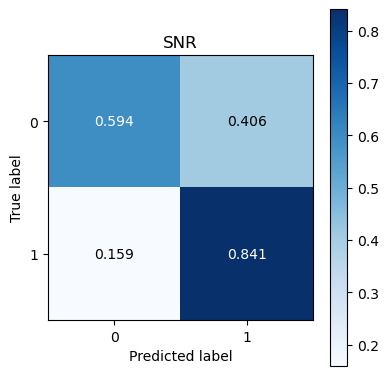

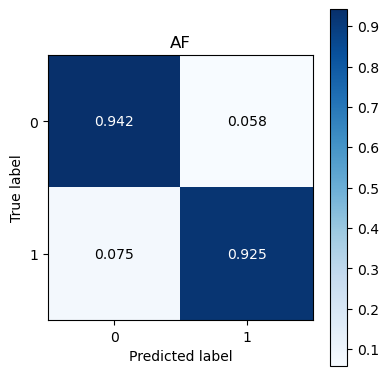

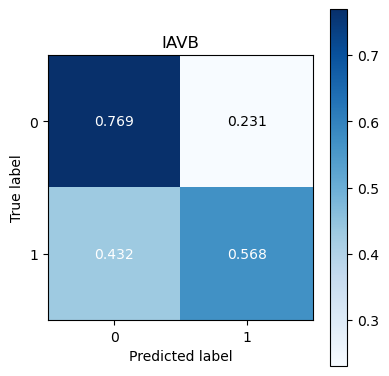

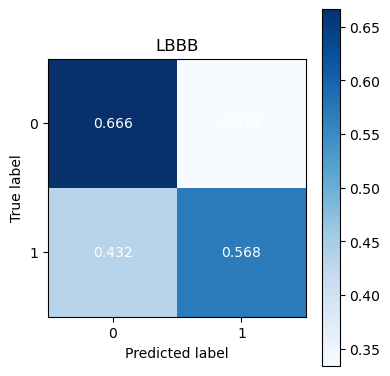

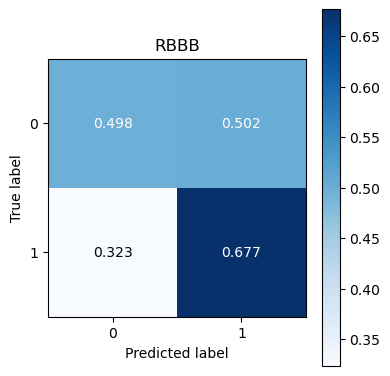

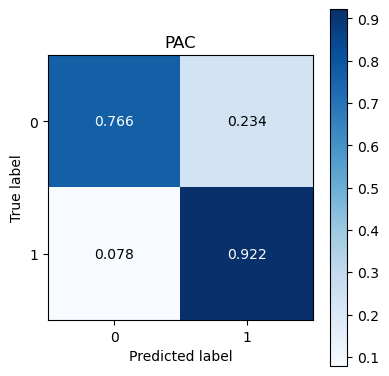

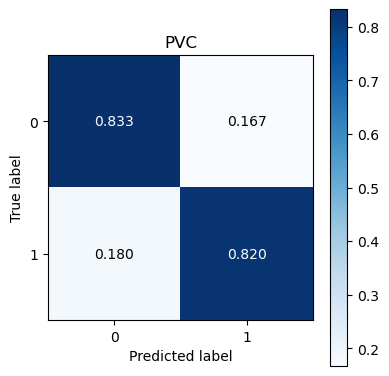

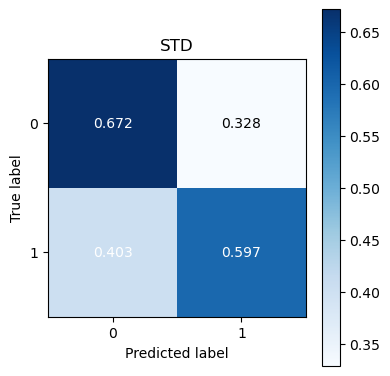

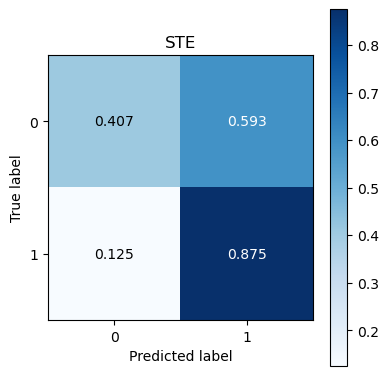

In [8]:
def plot_cm(y_trues, y_preds, normalize=True, cmap=plt.cm.Blues, classifier=classifier):
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    for i, label in enumerate(classes):
        y_true = y_trues[:, i]
        y_pred = y_preds[:, i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        opt_threshold = thresholds[np.argmax(tpr-fpr)]
        cm = confusion_matrix(y_true, y_pred >= opt_threshold)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)        
        ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=[0, 1], yticklabels=[0, 1],
           title=label,
           ylabel='True label',
           xlabel='Predicted label')
        plt.setp(ax.get_xticklabels(), ha="center")

        fmt = '.3f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        np.set_printoptions(precision=3)
        fig.tight_layout()
        plt.show()
        plt.savefig(f'results/{label}_{classifier}.png')
        plt.close()


if __name__ == "__main__":
    
    classifiers = ['RF', 'LR', 'LinerSVC', 'MLP']

    for classifier in classifiers:
        # tune parameters
        if classifier == 'RF':
            model = RandomForestClassifier() #n_estimators=300, max_depth=10)
        elif classifier == 'LR':
            model = LogisticRegression(max_iter=2000) #solver='lbfgs', max_iter=1000)
        elif classifier == 'LinearSVC':
            model = LinearSVC()
        else:
            model = MLPClassifier(max_iter=500) # hidden_layer_sizes=(100, 50), max_iter=500)
        if classifier != 'MLP':
            model = OneVsRestClassifier(model)

        print(f'Start training {classifier}...')
        model.fit(X_train, y_train)

        #y_val_scores = model.predict_proba(X_val)
        y_test_scores = model.predict_proba(X_test)
        # plot confusion matrix
        plot_cm(y_test, y_test_scores, classifier)

Start training RF...


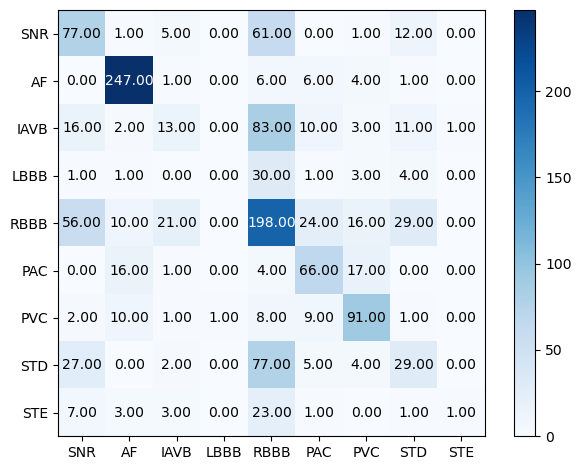

Start training LR...


<Figure size 640x480 with 0 Axes>

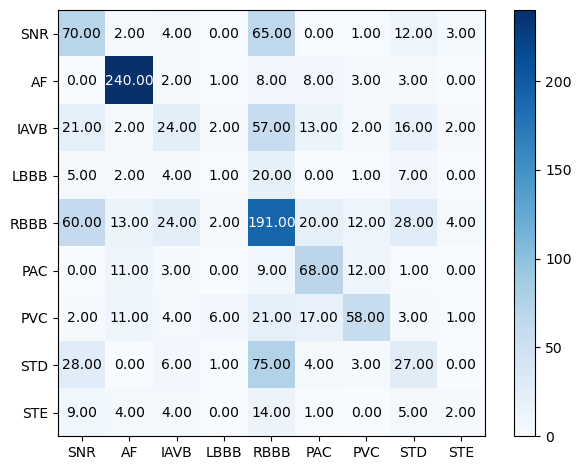

Start training LinerSVC...


<Figure size 640x480 with 0 Axes>

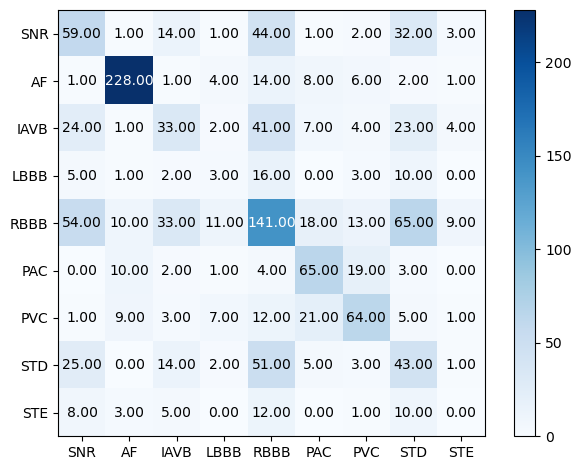

Start training MLP...


<Figure size 640x480 with 0 Axes>

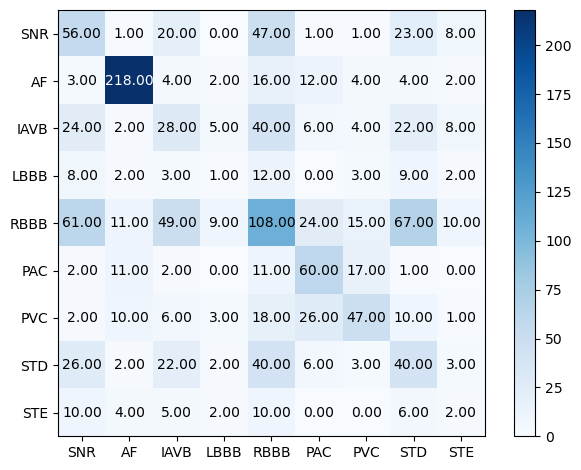

<Figure size 640x480 with 0 Axes>

In [9]:
def comp_confmat(y_true, y_test_scores, classifier=classifier, cmap=plt.cm.Blues):

    # extract the different classes
    classes = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']

    confusion_matrix = [[0 for _ in range(9)] for _ in range(9)]
    for true_label, predicted_label in zip(y_true, y_test_scores):
        true_index = true_label.argmax()
        predicted_index = predicted_label.argmax()
        if true_index == predicted_index:
            confusion_matrix[true_index][true_index] += 1
        else:
            confusion_matrix[true_index][predicted_index] += 1

    ys = np.array(confusion_matrix)
    fig, axs = plt.subplots()
    im = axs.imshow(ys, cmap=cmap)
    axs.figure.colorbar(im, ax=axs)
    fmt = '.2f'
    xlabels = classes
    ylabels = ['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    axs.set_xticks(np.arange(len(xlabels)))
    axs.set_yticks(np.arange(len(ylabels)))
    axs.set_xticklabels(xlabels)
    axs.set_yticklabels(ylabels)
    thresh = ys.max() / 2
    for i in range(ys.shape[0]):
        for j in range(ys.shape[1]):
            axs.text(j, i, format(ys[i, j], fmt),
                    ha='center', va='center',
                    color='white' if ys[i, j] > thresh else 'black')
    #np.set_printoptions(precision=2)
    fig.tight_layout()
    plt.show()
    plt.savefig(f'./cmatrix/{classifier}_cm.png')
    plt.clf()
    
if __name__ == '__main__':
    classifiers = ['RF', 'LR', 'LinerSVC', 'MLP']
    for classifier in classifiers:
        # tune parameters
        if classifier == 'RF':
            model = RandomForestClassifier() #n_estimators=300, max_depth=10)
        elif classifier == 'LR':
            model = LogisticRegression(max_iter=2000) #solver='lbfgs', max_iter=1000)
        elif classifier == 'LinearSVC':
            model = LinearSVC(max_iter=1000)
        else:
            model = MLPClassifier(max_iter=1000) #hidden_layer_sizes=(100, 50), max_iter=500)
        if classifier != 'MLP':
            model = OneVsRestClassifier(model)

        print(f'Start training {classifier}...')
        model.fit(X_train, y_train)

        #y_val_scores = model.predict_proba(X_val)
        y_test_scores = model.predict_proba(X_test)
        # plot confusion matrix
        comp_confmat(y_test, y_test_scores, classifier)